<h3> Create a spark session and load the Incident Management Data set

In [0]:
#import SparkSession
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('random_forest').getOrCreate()

In [0]:
# File Upload for all the models

file_location = "/FileStore/tables/airbnb.csv"
file_type = "csv"
 
# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
 
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
#check the shape of the data 
print((df.count(),len(df.columns)))

(3555, 23)


<h3> Data pre-processing

In [0]:
#printSchema
df.printSchema()

root
 |-- host_is_superhost: integer (nullable = true)
 |-- host_identity_verified: integer (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- Number_of_amenities: integer (nullable = true)
 |-- guests_included: integer (nullable = true)
 |-- price_per_extra_person: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- number_days_btw_first_last_review: integer (nullable = true)
 |-- review_scores_rating: integer (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- 

In [0]:
df=df.dropna()

<h3> Exploratory Data Analysis

In [0]:
#view the dataset
df.show(5)

+-----------------+----------------------+----------------------+-----------+------------+-------------+------------+------------+---------+--------+----+--------+-------------------+---------------+----------------------+--------------+-----------------+---------------------------------+--------------------+-------------------+-----+-------------+--------------+
|host_is_superhost|host_identity_verified|neighbourhood_cleansed|   latitude|   longitude|property_type|   room_type|accommodates|bathrooms|bedrooms|beds|bed_type|Number_of_amenities|guests_included|price_per_extra_person|minimum_nights|number_of_reviews|number_days_btw_first_last_review|review_scores_rating|cancellation_policy|price|price_gte_150|price_category|
+-----------------+----------------------+----------------------+-----------+------------+-------------+------------+------------+---------+--------+----+--------+-------------------+---------------+----------------------+--------------+-----------------+-------------

In [0]:
df.describe()

Out[292]: DataFrame[summary: string, host_is_superhost: string, host_identity_verified: string, neighbourhood_cleansed: string, latitude: string, longitude: string, property_type: string, room_type: string, accommodates: string, bathrooms: string, bedrooms: string, beds: string, bed_type: string, Number_of_amenities: string, guests_included: string, price_per_extra_person: string, minimum_nights: string, number_of_reviews: string, number_days_btw_first_last_review: string, review_scores_rating: string, cancellation_policy: string, price: string, price_gte_150: string, price_category: string]

<h3> Ramdom Forest

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml.classification import RandomForestClassifier

In [0]:
rf_classifier=RandomForestClassifier(labelCol='price_category_index',numTrees=50)

<h3> Data pre procesing

In [0]:
# Use StringIndexer to convert the categorical columns to hold numerical data
 
host_is_superhost_indexer = StringIndexer(inputCol='host_is_superhost',outputCol='host_is_superhost_index',handleInvalid='keep')
host_identity_verified_indexer = StringIndexer(inputCol='host_identity_verified',outputCol='host_identity_verified_index',handleInvalid='keep')
neighbourhood_cleansed_indexer = StringIndexer(inputCol='neighbourhood_cleansed',outputCol='neighbourhood_cleansed_index',handleInvalid='keep')
property_type_indexer = StringIndexer(inputCol='property_type',outputCol='property_type_index',handleInvalid='keep')
room_type_indexer = StringIndexer(inputCol='room_type',outputCol='room_type_index',handleInvalid='keep')
bed_type_indexer = StringIndexer(inputCol='bed_type',outputCol='bed_type_index',handleInvalid='keep')
cancellation_policy_group_indexer = StringIndexer(inputCol='cancellation_policy',outputCol='cancellation_policy_index',handleInvalid='keep')
price_category_indexer = StringIndexer(inputCol='price_category',outputCol='price_category_index',handleInvalid='keep')

In [0]:
# Vector assembler is used to create a vector of input features
 
assembler = VectorAssembler(inputCols=['host_is_superhost_index','host_identity_verified_index','neighbourhood_cleansed_index',
                                       'property_type_index','room_type_index','bed_type_index','cancellation_policy_index',
                                       'price_category_index','latitude','longitude','accommodates','bathrooms',
                                       'bedrooms','beds','Number_of_amenities','guests_included','price_per_extra_person',
                                       'minimum_nights','number_of_reviews','number_days_btw_first_last_review',
                                       'review_scores_rating','price','price_gte_150'],
                            outputCol="features")

In [0]:
pipe = Pipeline(stages=[host_is_superhost_indexer,host_identity_verified_indexer,neighbourhood_cleansed_indexer,property_type_indexer,room_type_indexer,bed_type_indexer,cancellation_policy_group_indexer,price_category_indexer,assembler,rf_classifier])

In [0]:
# Create a 70-30 train test split
 
train_data,test_data=df.randomSplit([0.7,0.3])

<h3> Model Training

In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe
 
results = fit_model.transform(test_data)

In [0]:
results.show()

+-----------------+----------------------+----------------------+-----------+------------+-------------+---------------+------------+---------+--------+----+-------------+-------------------+---------------+----------------------+--------------+-----------------+---------------------------------+--------------------+-------------------+-----+-------------+--------------+-----------------------+----------------------------+----------------------------+-------------------+---------------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|host_is_superhost|host_identity_verified|neighbourhood_cleansed|   latitude|   longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|     bed_type|Number_of_amenities|guests_included|price_per_extra_person|minimum_nights|number_of_reviews|number_days_btw_first_last_review|review_scores_rating|cancellation_policy|price|price_gte_150|price_category

<h3> Model Evaluation

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
rf_accuracy=MulticlassClassificationEvaluator(labelCol='price_category_index',metricName='accuracy').evaluate(results)

In [0]:
print('The accuracy of RF on test data is {0:.0%}'.format(rf_accuracy))

The accuracy of RF on test data is 100%


In [0]:
print(rf_accuracy)

1.0


In [0]:
rf_precision=MulticlassClassificationEvaluator(labelCol='price_category_index',metricName='weightedPrecision').evaluate(results)

In [0]:
print('The precision rate on test data is {0:.0%}'.format(rf_precision))

The precision rate on test data is 100%


In [0]:
rf_precision

Out[308]: 1.0

In [0]:
rf_auc=MulticlassClassificationEvaluator(labelCol='price_category_index').evaluate(results)

In [0]:
print(rf_auc)

1.0


In [0]:
# Feature importance

<h3> Apendix: Feature importance

In [0]:
# Vector assembler is used to create a vector of input features
 
assembler2 = VectorAssembler(inputCols=['host_is_superhost_index','host_identity_verified_index','neighbourhood_cleansed_index',
                                       'property_type_index','room_type_index','bed_type_index','cancellation_policy_index',
                                       'price_category_index','latitude','longitude','accommodates','bathrooms',
                                       'bedrooms','beds','Number_of_amenities','guests_included','price_per_extra_person',
                                       'minimum_nights','number_of_reviews','number_days_btw_first_last_review',
                                       'review_scores_rating','price','price_gte_150'],
                            outputCol="features")

In [0]:
pipe2 = Pipeline(stages=[host_is_superhost_indexer,host_identity_verified_indexer,neighbourhood_cleansed_indexer,property_type_indexer,room_type_indexer,bed_type_indexer,cancellation_policy_group_indexer,price_category_indexer,assembler2])

In [0]:
train_data2,test_data2=df.randomSplit([0.7,0.3])

In [0]:
train_df=pipe2.fit(train_data2)

In [0]:
# https://github.com/Apress/machine-learning-with-pyspark/blob/master/chapter_6_Random_Forests/Random_Forests.ipynb

In [0]:
rf_classifier=RandomForestClassifier(labelCol='price_category_index',numTrees=50).fit(train_data2)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
<command-2248947621643424> in <cell line: 1>()
----> 1 rf_classifier=RandomForestClassifier(labelCol='price_category_index',numTrees=50).fit(train_data2)

/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method(self, *args, **kwargs)
     28             call_succeeded = False
     29             try:
---> 30                 result = original_method(self, *args, **kwargs)
     31                 call_succeeded = True
     32                 return result

/databricks/spark/python/pyspark/ml/base.py in fit(self, dataset, params)
    203                 return self.copy(params)._fit(dataset)
    204             else:
--> 205                 return self._fit(dataset)
    206         else:
    207             raise TypeError(

/databricks/spark/python/pyspark/ml/wrapper.py in _fit(self, dataset)
    381 
 

In [0]:
fit_model.featureImportances

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2248947621643422> in <cell line: 1>()
----> 1 fit_model.featureImportances

AttributeError: 'PipelineModel' object has no attribute 'featureImportances'

In [0]:
importances = fit_model.featureImportances

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2248947621643441> in <cell line: 1>()
----> 1 importances = fit_model.featureImportances

AttributeError: 'PipelineModel' object has no attribute 'featureImportances'

In [0]:
df.schema["features"].metadata["ml_attr"]["attrs"]

<h3> Graph

In [0]:
import matplotlib.pyplot as plt

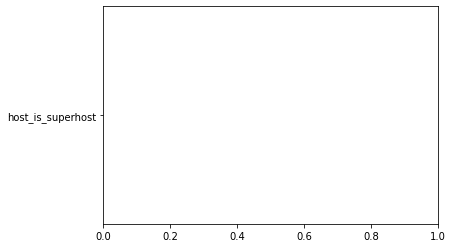

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-2248947621643439> in <cell line: 2>()
      1 importances = fit_model.stages[-1].featureImportances
----> 2 plt.barh(df.columns[:-1], importances)
      3 plt.show()

/databricks/python/lib/python3.9/site-packages/matplotlib/pyplot.py in barh(y, width, height, left, align, **kwargs)
   2664 @_copy_docstring_and_deprecators(Axes.barh)
   2665 def barh(y, width, height=0.8, left=None, *, align='center', **kwargs):
-> 2666     return gca().barh(
   2667         y, width, height=height, left=left, align=align, **kwargs)
   2668 

/databricks/python/lib/python3.9/site-packages/matplotlib/axes/_axes.py in barh(self, y, width, height, left, align, **kwargs)
   2511         """
   2512         kwargs.setdefault('orientation', 'horizontal')
-> 2513         patches = self.bar(x=left, height=height, width=width, bottom=y,
   2514         

In [0]:
importances = fit_model.stages[-1].featureImportances
plt.barh(df.columns[:-1], importances)
plt.show()